In [1]:
import glob
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from math import log, pi, exp
from tqdm import tqdm
import math

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# diffusion
num_steps = 4000

# model
# The output of a model doesn't have a range.
image_size = 64
in_channels = 3
hidden_channels = 128
num_heads = 4

# optimizer & scheduler
learn_rate = 0.0001
batch_size = 128
beta_schedule = "cosine"  # "linear"

# Prepare Dataset

**Pixel values ranges from -1 to 1!!!**

In [ ]:
data_dir = "D://datasets//faces"
batch_size = 32

class MyImageDataset(Dataset):
    def __init__(self, fnames):
        self.fnames = fnames
        self.num_samples = len(self.fnames)
        self.transform = transforms.Compose([
#             transforms.Grayscale(num_output_channels=1),
            transforms.Resize((64,64)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5), std=(0.5))
        ])

    def __getitem__(self, idx):
        fnames = self.fnames[idx]
        img = PIL.Image.open(fnames)
        img = self.transform(img)
        return img

    def __len__(self):
        return self.num_samples

def get_dataset(root):
    fnames = glob.glob(os.path.join(root, "*"))
    return MyImageDataset(fnames)


dataset = get_dataset(data_dir)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 64, 3])


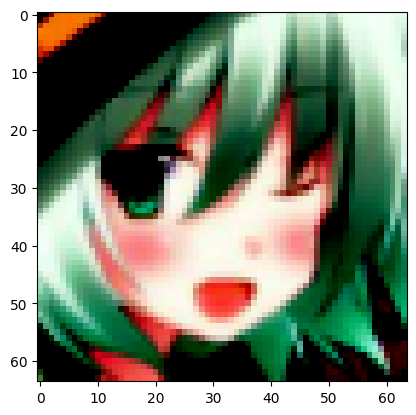

In [ ]:
# test
test_img = None
for data in dataloader:
    test_img = data
    break

test_img = test_img[0].permute(1, 2, 0)
print(test_img.shape)
plt.imshow(test_img)

# Timestep Scheduler #

In [ ]:
# big loss -> big self.weight -> higher probability to sample -> lower weight assigned to loss
#                              (to learn them more frequently)       (to stablize training)
class TimestepScheduler:
    def __init__(self, num_steps, max_num_history=10, uniform_prob=0.001):

        self.num_steps = num_steps
        self.uniform_prob = uniform_prob

        self.weights = torch.ones(num_steps)    # determines the probability of choosing a timestep

        self.max_num_history = max_num_history  # Maximum number of losses a timestep slot holds

        # there are <num_steps> slots. Each slot holds the history losses of the corresponding timestep
        self.loss_history = torch.zeros(num_steps, max_num_history)
        self.loss_counts = torch.zeros(num_steps).long()

    def sample(self, batch_size):
        # Normalize it in order to use
        weights_normalized = np.array(self.weights / self.weights.sum())
        timesteps = np.random.choice(self.num_steps, size=(batch_size,), p=weights_normalized)
        timesteps = torch.from_numpy(timesteps).long()

        weights_np = 1 / (self.num_steps * weights_normalized[timesteps])
        weights = torch.from_numpy(weights_np).float()

        return timesteps, weights

    # Reschedule based on the new loss
    # Remember to detach losses and t
    def step(self, losses, ts):
        # update loss
        for t, loss in zip(ts, losses):
            # the slot is filled, then remove the last history
            if self.loss_counts[t] == self.max_num_history:
                self.loss_history[t, :-1] = self.loss_history[t, 1:].clone()
                self.loss_history[t, -1] = loss
            # the slot is not filled, then simply add the new loss
            else:
                self.loss_history[t, self.loss_counts[t]] = loss
                self.loss_counts[t] += 1

        # update weight
        if not self.is_warmed_up():
            return
        self.weights = (torch.sum(self.loss_history**2, 1) / self.num_steps).sqrt()  # length of each timestep's loss
        self.weights = self.weights / self.weights.sum()  # normalize
        self.weights = (1 - self.uniform_prob) * self.weights + self.uniform_prob * (1 / self.num_steps) # to prevent zero weight
        # big loss -> big weight

    def is_warmed_up(self):
        # warmed up if every slot is filled
        return (self.loss_counts == self.max_num_history).all()


scheduler = TimestepScheduler(num_steps)
timesteps, weights = scheduler.sample(batch_size=10)

print(timesteps)
print(weights)
print(scheduler.is_warmed_up())

tensor([3951, 1880, 2207, 2731, 1041, 1158, 1055, 3438, 2975, 2300])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor(False)


In [ ]:
# test
a = 0
while not scheduler.is_warmed_up():
    timesteps, weights = scheduler.sample(batch_size=batch_size)
    loss = torch.rand(batch_size)
    scheduler.step(loss, timesteps)
    a += 1
print(a)

timesteps, weights = scheduler.sample(batch_size=batch_size)
print(scheduler.weights)
print(weights)

print(scheduler.weights.shape)
print(weights.shape)

0
tensor([4.0780e-04, 1.9373e-05, 3.3295e-04,  ..., 9.2537e-05, 3.5624e-04,
        4.5002e-04])
tensor([0.6216, 1.4489, 1.2161, 1.0072, 0.9318, 1.6471, 0.9070, 0.6857, 0.5515,
        0.5510, 0.8487, 0.6370, 0.8466, 0.6362, 0.6723, 0.5469, 1.0911, 0.7533,
        0.7163, 0.5161, 0.5075, 0.6072, 1.0301, 0.5958, 1.5139, 0.5146, 0.5700,
        0.7765, 1.2576, 0.8405, 0.5072, 0.5987, 1.1898, 0.5566, 0.6409, 0.6406,
        1.3856, 0.5965, 0.7184, 0.8342, 0.7001, 0.5727, 1.0845, 0.8439, 0.7535,
        1.4008, 0.8087, 0.5567, 1.0064, 0.5884, 0.6933, 0.9428, 0.8405, 0.7345,
        0.6063, 0.8242, 0.8946, 0.6852, 0.7130, 0.5125, 0.6125, 1.0014, 0.5212,
        0.7646, 1.3491, 0.7356, 0.9962, 0.5396, 0.5779, 0.7047, 0.5205, 1.0576,
        0.6208, 0.7303, 0.9926, 0.8591, 1.7309, 0.5970, 0.5368, 1.1064, 0.7564,
        0.5583, 1.0386, 0.5717, 2.0498, 1.1769, 0.5489, 4.6352, 1.9233, 0.6517,
        3.0563, 0.6222, 0.5298, 0.9590, 0.6507, 0.6965, 1.8540, 0.5387, 3.3495,
        0.5992, 1.9227,

# Beta Scheduler

In [ ]:
def getBeta(num_steps=num_steps, beta_schedule="cosine"):
    if beta_schedule == "cosine":
        max_beta = 0.999
        s = 0.008
        def f(t):
            T = num_steps
            return torch.cos((t / T + s) / (1 + s) * (torch.pi / 2)) ** 2
        t = torch.tensor(range(0, num_steps))
        alpha_bar = f(t) / f(torch.tensor([0]))
        alpha_bar_prev = torch.cat([torch.ones(1), alpha_bar[:-1]], dim=0)
        beta = 1 - alpha_bar / alpha_bar_prev
        beta = torch.min(beta, torch.ones_like(beta) * max_beta)
        return beta

    elif beta_schedule == "linear":
        scale = 1000 / num_steps

        beta_start = scale * 0.0001
        beta_end = scale * 0.02
        beta = torch.linspace(beta_start, beta_end, num_steps)
        return beta

    else:
        print("unknown beta schedule")

beta = None
alpha = None
alpha_bar = None
alpha_bar_prev = None
alpha_bar_next = None

one_minus_alpha_bar = None
log_one_minus_alpha_bar = None

sqrt_alpha_bar = None
sqrt_one_minus_alpha_bar = None
sqrt_one_over_alphas_bar = None
sqrt_one_over_alphas_bar_minus_one = None
def initialize_parameters(num_steps=num_steps, beta_schedule="cosine"):
    global beta
    global alpha
    global alpha_bar
    global alpha_bar_prev
    global alpha_bar_next

    global one_minus_alpha_bar
    global log_one_minus_alpha_bar

    global sqrt_alpha_bar
    global sqrt_one_minus_alpha_bar
    global sqrt_one_over_alphas_bar
    global sqrt_one_over_alphas_bar_minus_one

    beta = getBeta(num_steps=num_steps, beta_schedule=beta_schedule)
    alpha = 1 - beta
    alpha_bar = torch.cumprod(alpha, dim=0)
    alpha_bar_prev = torch.cat([torch.ones(1), alpha_bar[:-1]], dim=0)  # the first one is set to 1 because we want x0 be added no noise
    alpha_bar_next = torch.cat([alpha_bar[:-1], torch.zeros(1)], dim=0)

    one_minus_alpha_bar = 1 - alpha_bar
    log_one_minus_alpha_bar = torch.log(one_minus_alpha_bar)

    sqrt_alpha_bar = torch.sqrt(alpha_bar)
    sqrt_one_minus_alpha_bar = torch.sqrt(one_minus_alpha_bar)
    sqrt_one_over_alphas_bar = torch.sqrt(1.0 / alpha_bar)
    sqrt_one_over_alphas_bar_minus_one = torch.sqrt(1.0 / alpha_bar - 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([   0,  400,  800, 1200, 1600, 2000, 2400, 2800, 3200, 3600, 3999])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

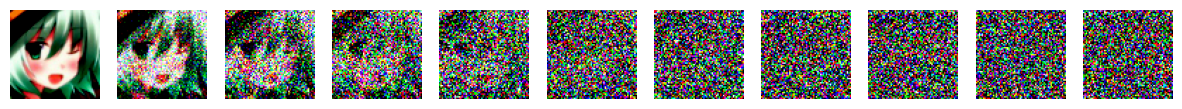

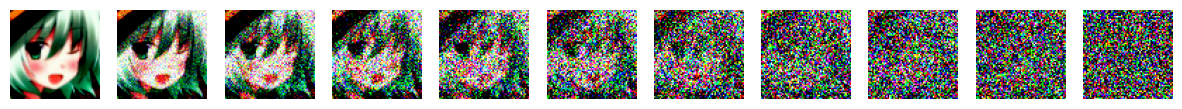

In [ ]:
# test
def get_xt(x0, t):
    return x0 * sqrt_alpha_bar[t] + torch.randn_like(x0) * sqrt_one_minus_alpha_bar[t]

steps = torch.cat([torch.tensor(range(num_steps))[::400], torch.tensor([3999])], 0)
print(steps)

# linear
initialize_parameters(num_steps=num_steps, beta_schedule="linear")
fig, axs = plt.subplots(1, 11, figsize=(15, 40))
for i in range(0, len(steps)):
    step = steps[i]
    noisy_image = get_xt(test_img, step)
    axs[i].imshow(noisy_image, cmap='gray')
    axs[i].set_axis_off()


# cosine
initialize_parameters(num_steps=num_steps, beta_schedule="cosine")
fig, axs = plt.subplots(1, 11, figsize=(15, 40))
for i in range(0, len(steps)):
    step = steps[i]
    noisy_image = get_xt(test_img, step)
    axs[i].imshow(noisy_image, cmap='gray')
    axs[i].set_axis_off()

$$x_t = \sqrt{\bar{\alpha}_t}x_0 + \sqrt{1 - \bar{\alpha}_t}z$$

Text(0.5, 1.0, 'sqrt_one_minus_alpha_bar')

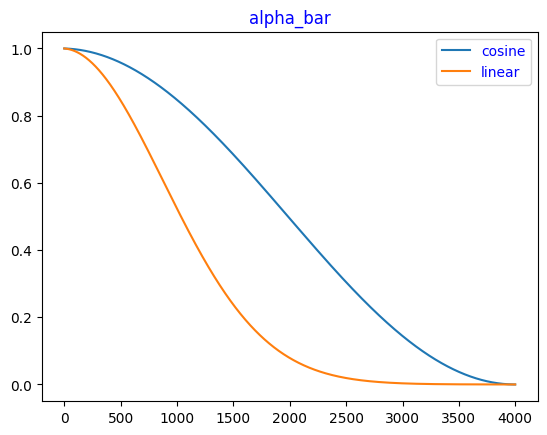

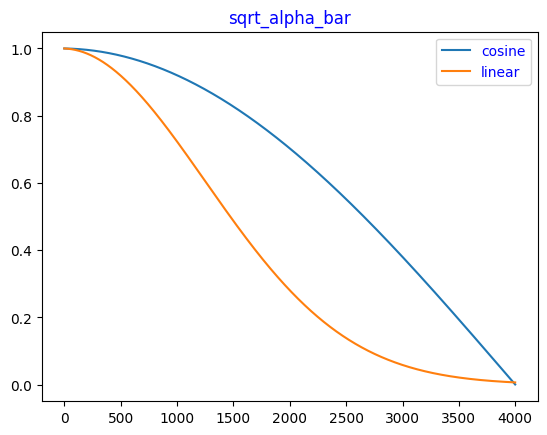

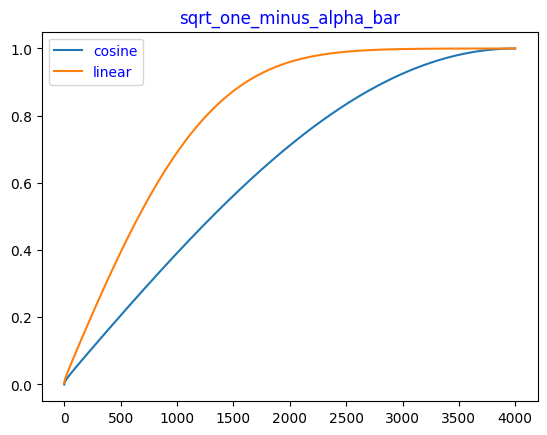

In [ ]:
plt.figure(0)
initialize_parameters(num_steps=num_steps, beta_schedule="cosine")
plt.plot(range(num_steps), alpha_bar, label="cosine")
initialize_parameters(num_steps=num_steps, beta_schedule="linear")
plt.plot(range(num_steps), alpha_bar, label="linear")
plt.legend()
plt.title("alpha_bar")

plt.figure(1)
initialize_parameters(num_steps=num_steps, beta_schedule="cosine")
plt.plot(range(num_steps), sqrt_alpha_bar, label="cosine")
initialize_parameters(num_steps=num_steps, beta_schedule="linear")
plt.plot(range(num_steps), sqrt_alpha_bar, label="linear")
plt.legend()
plt.title("sqrt_alpha_bar")

# the variance is added more progressively
plt.figure(2)
initialize_parameters(num_steps=num_steps, beta_schedule="cosine")
plt.plot(range(num_steps), sqrt_one_minus_alpha_bar, label="cosine")
initialize_parameters(num_steps=num_steps, beta_schedule="linear")
plt.plot(range(num_steps), sqrt_one_minus_alpha_bar, label="linear")
plt.legend()
plt.title("sqrt_one_minus_alpha_bar")

# Diffusion process and Loss Function

Add noise
$$x_t = \sqrt{\bar{\alpha}_t}x_0 + \sqrt{1 - \bar{\alpha}_t}z$$

In [ ]:
# q(xt | x0)
def q_mean_variance(x0, t):
    mean = sqrt_alpha_bar[t] * x0
    std = sqrt_one_minus_alpha_bar[t]
    variance = 1 - alpha_bar[t]
    log_variance = log_one_minus_alpha_bar[t]
    return mean, std, variance, log_variance

def q_sample(x0, t, noise=None):
    if noise == None:  # we give a noise for training and set it to None for generating images
        noise = torch.randn_like(x0)
    mean, std, variance, log_variance = q_mean_variance(x0, t)
    return mean + noise * std

q posterior
$$q(x_{t-1}|x_t, x_0) = \mathcal{N}(x_{t-1} | \tilde{\mu}_t, \tilde{\beta}_t)$$

$$\tilde{\beta}_t = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_{t}}\beta_t$$

$$\tilde{\mu}_t = \frac{\sqrt{\alpha_t} (1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha_t}}x_t + \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1 - \bar{\alpha}_t} x_0$$

In [ ]:
# q(xt-1 | xt, x0)
posterior_variance = (1 - alpha_bar_prev) / one_minus_alpha_bar * beta
posterior_log_variance = torch.log(posterior_variance)
coeff1 = torch.sqrt(alpha) * (1 - alpha_bar_prev) / (1 - alpha_bar)
coeff2 = torch.sqrt(alpha_bar_prev) * beta / (1 - alpha_bar)
def q_posterior_mean_variance(xt, x0, t):
    beta_tilde = posterior_variance[t]
    log_beta_tilde = posterior_log_variance[t]
    mu_tilde = coeff1[t] * xt + coeff2[t] * x0
    return mu_tilde, beta_tilde, log_beta_tilde

# When calculating posterior of q, we can't use the equation below, because z is not given.
# But when we predict z with model, we can use the our predicted z and the equation below to obtain mean (by expressing x0 with z and xt).

print(posterior_variance)    # As mentioned before, we set alpha_bar_prev to 1 in t0. Thus, the first variance is 0.
print(posterior_log_variance)

tensor([0.0000e+00, 1.2801e-05, 1.7888e-05,  ..., 4.9975e-03, 4.9988e-03,
        5.0000e-03])
tensor([    -inf, -11.2660, -10.9314,  ...,  -5.2988,  -5.2986,  -5.2983])


Prediction of $x_{t-1}$ (This is obtained by first predicting x0 with the predicted noise and then plug it into the posterior q)
$$\tilde{\mu}_t = \frac{1}{\sqrt{\alpha_t}}(x_t - \frac{\beta_t}{\sqrt{1-\bar{a_t}}}z_t)$$

$$\Sigma_\theta(x_t, t) = exp(v log(\beta_t) + (1-v) log(\tilde{\beta}_t))$$

In [ ]:
# p(xt-1 | xt)
def p_mean_variance(model, xt, t):
    model_output, model_var_values = torch.split(model(xt, t), in_channels, dim=1)

    # Handle the second term  (case1: log variance. case2: predict fraction)
    # We can directly predict log variance by doing: model_log_variance = model_var_values
    # Here we choose to interpolate between beta and beta_tilde:
    v = (model_var_values + 1) / 2   # (-1, 1)  =>  (0, 1)
    model_log_variance = v * torch.log(beta[t]) + (1-v) * posterior_log_variance[t]
    model_variance = torch.exp(model_log_variance)

    # Handle the first term (case1: x0. case2: mean of xt-1. case3: epsilon)
    # case1
    # pred_x0 = model_output
    # case2
    # pred_mu_tilde = model_output
    # pred_x0 = pred_x0_from_xprev(xt, pred_mu_tilde, t)  # explained below
    # case3
    epsilon = model_output
    pred_x0 = pred_x0_from_epsilon(xt, epsilon, t)
    pred_x0 = pred_x0.clamp(-1, 1)  # x0 must be in (-1, 1). mu doesn't.

    # Having x0, we can obtain mu_tilde (we don't need to do this if we chose case2 of course)
    pred_mu_tilde, _, _ = q_posterior_mean_variance(xt, pred_x0, t)
    # We can also predict mu_tilde by using the first equation above, but since we have pred_x0, we can simply
    # use function <q_posterior_mean_variance> we've already created.
    return pred_mu_tilde, model_variance, model_log_variance, pred_x0, epsilon

def sample_p(model, xt, t):
    pred_mu_tilde, model_variance, model_log_variance, pred_x0, epsilon = p_mean_variance(model, xt, t)
    nonzero_mask = (t!=0).float()   # x0 has no variance added on it
    return pred_mu_tilde + nonzero_mask * torch.randn_like(pred_mu_tilde) * torch.exp(0.5 * model_log_variance)

def generate_image(model, batch_size, num_steps=num_steps):
    x_t = []
    x_t.append(torch.randn(batch_size, in_channels, image_size, image_size))
    for t in range(num_steps)[::-1]:
        t = torch.ones(batch_size, 1, 1, 1).long() * t
        cur_x = x_t[-1]
        with torch.no_grad():
            cur_x = sample_p(model, cur_x, t)
        x_t.append(cur_x)

    return x_t

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

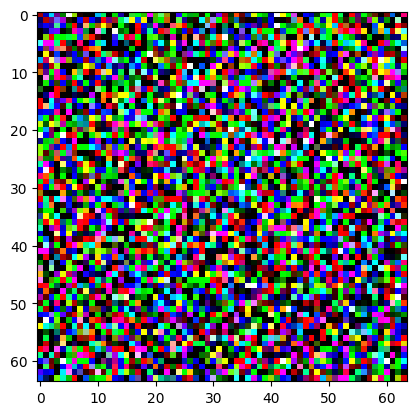

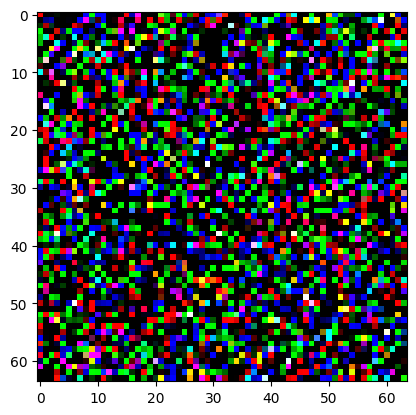

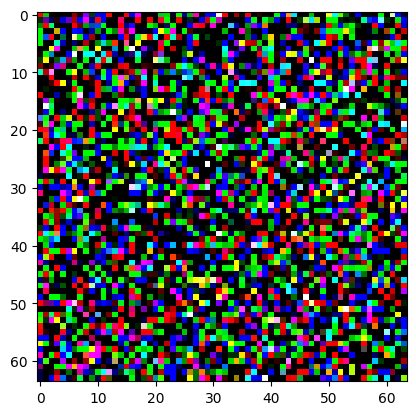

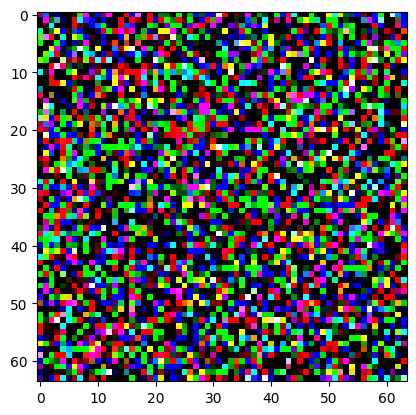

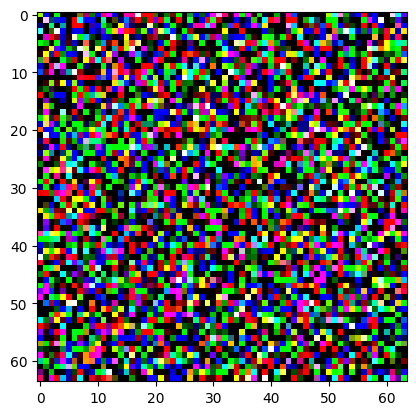

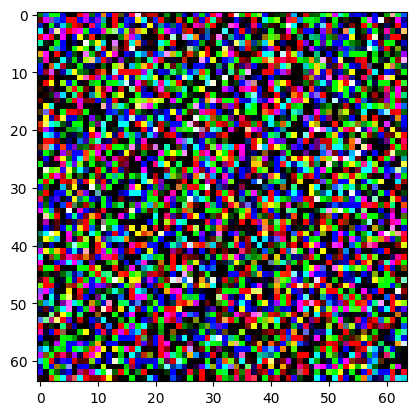

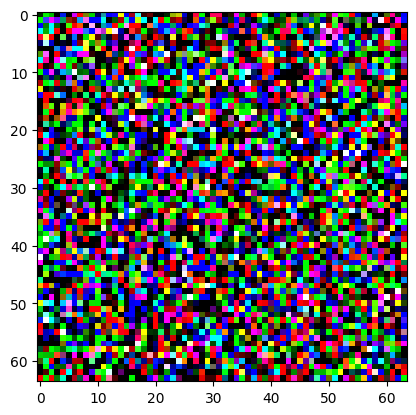

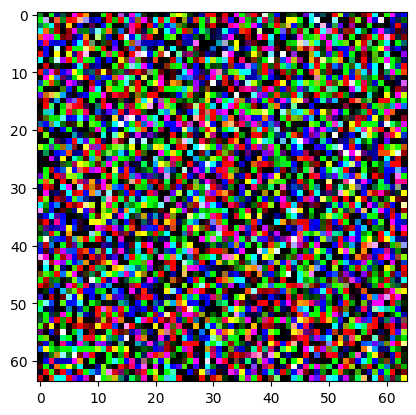

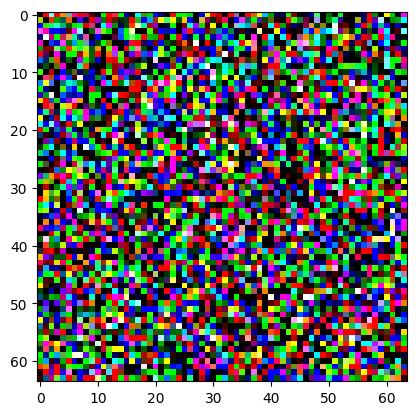

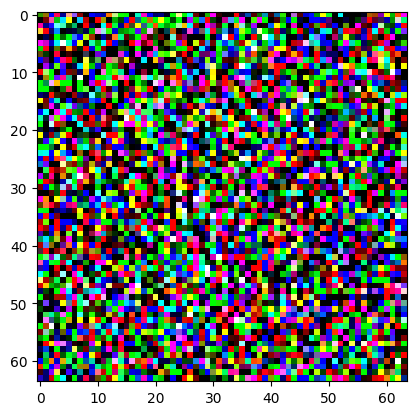

In [ ]:
# test
class AttentionUNet(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_heads, num_steps):
        super(AttentionUNet, self).__init__()
        self.conv = nn.Conv2d(in_channels, 2*in_channels, 3, padding=1)
    def forward(self, x, t):
        return torch.sigmoid(self.conv(x))

model = AttentionUNet(in_channels, hidden_channels, num_heads, num_steps)
generated_image = generate_image(model, 1)
for i in range(0, 10):
    plt.figure(i)
    img = generated_image[-i * 400][0]
    plt.imshow(img.permute(1, 2, 0))

To predict $x_0$ from $x_t$ and $x_{t-1}$, we take the reverse of:
$$\tilde{\mu}_t = \frac{\sqrt{\alpha_t} (1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha_t}}x_t + \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1 - \bar{\alpha}_t} x_0$$

In [ ]:
def pred_x0_from_mu_tilde(xt, pred_mu_tilde, t):
    return (pred_mu_tilde - coef1[t] * xt) / coef2[t]

To predict $x_0$ from $x_t$ and $\epsilon$, we tke the reverse of:
$$x_t = \sqrt{\bar{\alpha}_t}x_0 + \sqrt{1 - \bar{\alpha}_t}z$$

In [ ]:
def pred_x0_from_epsilon(xt, epsilon, t):
    return sqrt_one_over_alphas_bar[t] * xt - sqrt_one_over_alphas_bar_minus_one[t] * epsilon

# TODO: DDIM Implementation

# Loss

Loss
$$L_{hybrid} = L_{simple} + L_{vlb}$$

KL divergence of two Normal Distributions:
$$KL(p,q) = log\sigma_q - log\sigma_p + \frac{\sigma_p^2+(\mu_p−\mu_q)^2}{2\sigma_q^2} − \frac{1}{2}$$

In [ ]:
# Different from DDPM, we brought L_vlb back because we are not only predicting the noise, but also the variance, which doesn't appear in
# L_simple. Since we are maximizing the lower bound.

# KL(p||q)
def calc_gaussian_KL_Divergence(p_mean, p_log_variance, q_mean, q_log_variance):
    return 0.5 * (
        q_log_variance
        - p_log_variance
        + torch.exp(p_log_variance - q_log_variance)
        + (p_mean - q_mean)**2 * torch.exp(-q_log_variance)
        - 1
    )


def cals_loss(model, x0, t):
    noise = torch.randn_like(x0)
    xt = q_sample(x0, t)
# 1. L_vlb
    # There are two parts: L_t-1 and L0
    # Part1: L_t-1 is simply a KL divergence
    true_posterior_mean, true_posterior_variance, true_posterior_log_variance = q_posterior_mean_variance(xt, x0, t)
    pred_mean, pred_variance, pred_log_variance, pred_x0, epsilon = p_mean_variance(model, xt, t)
    # We want to calculate KL(q||p)
    L_t_minus_one = calc_gaussian_KL_Divergence(true_posterior_mean, true_posterior_log_variance, pred_mean, pred_log_variance)

    # Part2: x0 doesn't have variance. So we shouldn't use KL divergence. As suggested in DDPM, this should be a negative log lokelihood.
    # Pixels are discrete target. Thus it's more reasonable to use discrete gaussian likelihood. (coded below)
    L_0 = -discretized_gaussian_log_likelihood(x0, pred_mean, log_scales=0.5 * pred_log_variance)
    L_vlb = torch.where((t == 0), L_0, L_t_minus_one)
    L_vlb = torch.mean(L_vlb, dim=(1, 2, 3), keepdim=True)

# 2. L_simple
    L_simple = (noise - epsilon)**2  # bs * 3 * 64 * 64
    L_simple = torch.mean(L_simple, dim=(1, 2, 3), keepdim=True)

    Loss = L_vlb * num_steps / 1000 + L_simple

    return L_vlb, L_simple, Loss

### How does this discrete likelihood work?

First let's consider pixel values ranging from 0 to 225.
Let's denote $x_0' \in (0, 225)$. $x' \in (0, 225)$
Then 2.5 and 3.49 will both be rounded to 3. In this case, we have:

$$p(x'=x_0') = p(x_0'-0.5 < x' < x_0'+0.5)$$

Now we do transformation $x_0 = \frac{x_0'}{127.5} - 1$, $x = \frac{x'}{127.5} - 1$, so that $x_0$ and $x$ ranges from -1 to 1. Then

$$p(x=x_0) = p(x'=x_0') = p(x_0'-0.5 < x' < x_0'+0.5)$$

$$= p(127.5(x_0+1)-0.5 < 127.5(x+1) < 127.5(x_0+1)+0.5)$$

$$= p(127.5x_0-0.5 < 127.5x < 127.5x_0+0.5)$$

$$= p(x_0-\frac{1}{225} < x < x_0+\frac{1}{225})$$

By CLT:

$$= \phi(\frac{(x_0-x)+\frac{1}{225}}{\sigma}) - \phi(\frac{(x_0-x)-\frac{1}{225}}{\sigma})$$

($\phi$ is the CDF of standard gaussian distribution)

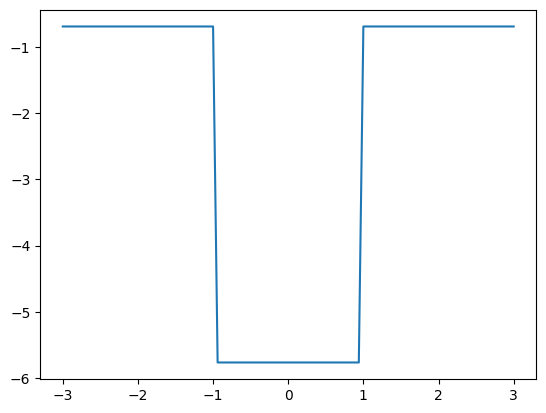

In [10]:
# Directly copied from openai
def approx_standard_normal_cdf(x):
    return 0.5 * (1.0 + torch.tanh(np.sqrt(2.0 / np.pi) * (x + 0.044715 * torch.pow(x, 3))))

def discretized_gaussian_log_likelihood(x, means, log_scales):
    centered_x = x - means
    inv_stdv = torch.exp(-log_scales)

    plus_in = inv_stdv * (centered_x + 1.0 / 255.0)
    cdf_plus = approx_standard_normal_cdf(plus_in)

    min_in = inv_stdv * (centered_x - 1.0 / 255.0)
    cdf_min = approx_standard_normal_cdf(min_in)

    cdf_delta = cdf_plus - cdf_min
    log_cdf_plus = torch.log(cdf_plus.clamp(min=1e-12)) # ensure that value is not -inf
    log_one_minus_cdf_min = torch.log((1.0 - cdf_min).clamp(min=1e-12))

    # ??? x in (-1, 1)
    log_probs = torch.where(
        x < -0.999,
        log_cdf_plus,
        torch.where(x > 0.999, log_one_minus_cdf_min, torch.log(cdf_delta.clamp(min=1e-12))),
    )
    # log_probs = torch.log(cdf_delta.clamp(min=1e-12))
    assert log_probs.shape == x.shape
    return log_probs


x0 = torch.linspace(-3, 3, 100).double()
x = torch.linspace(-3, 3, 100).double()
log_scales = torch.log(torch.linspace(1, 1, 100)).double()
likelihood = discretized_gaussian_log_likelihood(x0, x, log_scales)
plt.plot(x, likelihood)

# Model

### Position Embedding

In [ ]:
t = torch.randint(0, 10, (10,))

# Traditional Method.
# embedding: sin, cos, sin, cos...
def GetPositionEmbedding1D(sequence_indices, embedding_len):
    div = 10000 ** (torch.arange(0, embedding_len // 2) * 2 / embedding_len)
    positions = sequence_indices.unsqueeze(1)
    pos_emb = torch.zeros(sequence_indices.shape[0], embedding_len)
    pos_emb[:, 0::2] = torch.sin(positions / div)
    pos_emb[:, 1::2] = torch.cos(positions / div)
    return pos_emb

print(GetPositionEmbedding1D(t, 6))

# Method used in openai code
# embedding: cos, cos, ..., sin, sin, ...
def GetPositionEmbedding1D(sequence_indices, embedding_len):
    div = 10000 ** (torch.arange(0, embedding_len // 2) * 2 / embedding_len)
    positions = sequence_indices.unsqueeze(1)
    pos_emb = torch.zeros(sequence_indices.shape[0], embedding_len)
    pos_emb[:, embedding_len//2:] = torch.sin(positions / div)
    pos_emb[:, :embedding_len//2] = torch.cos(positions / div)
    return pos_emb

print(GetPositionEmbedding1D(t, 6))

tensor([[ 0.8415,  0.5403,  0.0464,  0.9989,  0.0022,  1.0000],
        [ 0.9093, -0.4161,  0.0927,  0.9957,  0.0043,  1.0000],
        [ 0.8415,  0.5403,  0.0464,  0.9989,  0.0022,  1.0000],
        [-0.2794,  0.9602,  0.2749,  0.9615,  0.0129,  0.9999],
        [ 0.4121, -0.9111,  0.4057,  0.9140,  0.0194,  0.9998],
        [ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.1411, -0.9900,  0.1388,  0.9903,  0.0065,  1.0000],
        [-0.2794,  0.9602,  0.2749,  0.9615,  0.0129,  0.9999],
        [ 0.9894, -0.1455,  0.3629,  0.9318,  0.0172,  0.9999]])
tensor([[ 0.5403,  0.9989,  1.0000,  0.8415,  0.0464,  0.0022],
        [-0.4161,  0.9957,  1.0000,  0.9093,  0.0927,  0.0043],
        [ 0.5403,  0.9989,  1.0000,  0.8415,  0.0464,  0.0022],
        [ 0.9602,  0.9615,  0.9999, -0.2794,  0.2749,  0.0129],
        [-0.9111,  0.9140,  0.9998,  0.4121,  0.4057,  0.0194],
        [ 1.0000,  1.0000,  1.0000,  0.

### Some Utility classes

In [ ]:
def zero_module(module):
  """
  Zero out the parameters of a module and return it.
  """
  for p in module.parameters():
    p.detach().zero_()
  return module

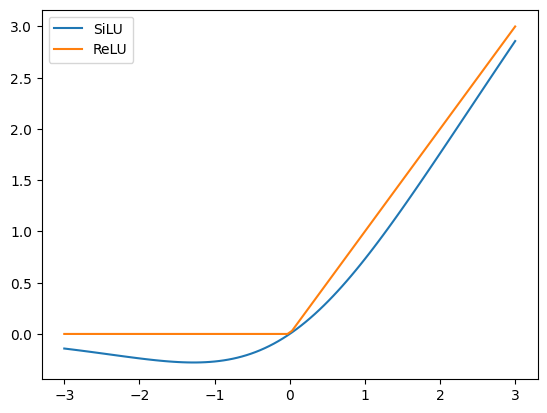

In [ ]:
class SiLU(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

silu = SiLU()
relu = nn.ReLU()
x = torch.linspace(-3, 3, 100)
plt.plot(x, silu(x), label="SiLU")
plt.plot(x, relu(x), label="ReLU")
plt.legend()

### Modules

In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, hidden_channels, num_heads=4):
    super(SelfAttention, self).__init__()

    self.num_heads = num_heads
    self.head_dim = hidden_channels // num_heads

    self.norm = nn.GroupNorm(32, hidden_channels)
    self.toQKV = nn.Conv1d(hidden_channels, 3*hidden_channels, kernel_size=1)
    self.out = zero_module(nn.Conv1d(hidden_channels, hidden_channels, kernel_size=1))

  def forward(self, x):
    bs, C, H, W = x.shape
    L = H * W
    x = x.reshape(x.shape[0], x.shape[1], -1)
    x = self.norm(x)  # B * C * L

    qkv = self.toQKV(x)  # B * 3C * L
    qkv = qkv.reshape(bs * num_heads, -1, L)  # B*num_heads * 3head_dim * L
    q, k, v = torch.split(qkv, self.head_dim, dim=1)    # B*num_heads * head_dim * L
    div = torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))

    attention_weight = torch.matmul(q.permute(0, 2, 1), k) / div # B*num_heads * L * L
    attention_weight = torch.softmax(attention_weight, dim=-1)
    h = torch.einsum("bts,bcs->bct", attention_weight, v)  # B*num_heads * head_dim * L
    h = h.reshape(bs, -1, L)  # B * C * L
    h = self.out(h)
    return (x + h).reshape(bs, C, H, W)


# Doesn't change channels.
# Halve the image size
class Downsample(nn.Module):
    def __init__(self, channels):
        super(Downsample, self).__init__()
        self.conv = nn.Conv2d(channels, channels, 3, stride=2, padding=1)

    def forward(self, x):
        return self.conv(x)

# Doesn't change channels
# Double the image size
class Upsample(nn.Module):
    def __init__(self, channels):
        super(Upsample, self).__init__()
        self.conv = nn.Conv2d(channels, channels, 3, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode="nearest")  # Double the size of the image by repeating each element
        x = self.conv(x)
        return x

class ResBlock(nn.Module):
    def __init__(self, channels, out_channels, emb_channels):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels
        self.emb_channels = emb_channels

        # For x
        self.in_layers = nn.Sequential(
            nn.GroupNorm(32, channels),
            SiLU(),
            nn.Conv2d(channels, self.out_channels, 3, padding=1),
        )

        # For embedding
        self.emb_layers = nn.Sequential(
            SiLU(),
            nn.Linear(emb_channels, 2 * self.out_channels)
        )

        # Final Layer
        self.out_layers = nn.Sequential(
            nn.GroupNorm(32, self.out_channels),
            SiLU(),
            nn.Dropout(p=0),
            zero_module(
                nn.Conv2d(self.out_channels, self.out_channels, 3, padding=1)
            )
        )

        # Scale if input output shapes don't match
        if self.out_channels == channels:
            self.skip_connection = nn.Identity()
        else:
            self.skip_connection = nn.Conv2d(channels, self.out_channels, 3, padding=1)

    def forward(self, x, emb):
        h = self.in_layers(x)
        emb_out = self.emb_layers(emb)

        # Mysterious operations
        out_norm, out_rest = self.out_layers[0], self.out_layers[1:]
        scale, shift = torch.chunk(emb_out, 2, dim=1)
        # print(scale.shape, shift.shape)   # bs * 128
        h = out_norm(h) * (1 + scale.unsqueeze(-1).unsqueeze(-1)) + shift.unsqueeze(-1).unsqueeze(-1)   # Scale and shift the latent variable based on the embedding
        h = out_rest(h)

        return self.skip_connection(x) + h
m = ResBlock(1024, 512, 512)
print(m.type)

<bound method Module.type of ResBlock(
  (in_layers): Sequential(
    (0): GroupNorm(32, 1024, eps=1e-05, affine=True)
    (1): SiLU()
    (2): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (emb_layers): Sequential(
    (0): SiLU()
    (1): Linear(in_features=512, out_features=1024, bias=True)
  )
  (out_layers): Sequential(
    (0): GroupNorm(32, 512, eps=1e-05, affine=True)
    (1): SiLU()
    (2): Dropout(p=0, inplace=False)
    (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (skip_connection): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)>


In [ ]:
# in_channels: 3
# out_channels: 6
# embedding_dims: 4 * 128 = 512
# hidden_channels: [128, 256, 374, 512]

class AttentionUNet(nn.Module):
    def __init__(self, in_channels, num_heads, num_steps):
        super(AttentionUNet, self).__init__()

        out_channels = 2 * in_channels  # We predict mean and variance of epsilon
        channel_mult = [1, 2, 3, 4]
        hidden_channels = [128, 256, 384, 512]

        # Embedding
        time_embed_dim = 4 * 128
        self.time_embedding = nn.Sequential(
            nn.Linear(128, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        # Down Sampling
        self.input_blocks = nn.ModuleList([
            nn.Conv2d(in_channels, 128, 3, padding=1), # 128
            ResBlock(128, 128, time_embed_dim), # 128, 128
            ResBlock(128, 128, time_embed_dim), # 128, 128, 128
            ResBlock(128, 128, time_embed_dim), # 128, 128, 128, 128

            Downsample(128),            # 128, 128, 128, 128, 128
            ResBlock(128, 256, time_embed_dim), # 128, 128, 128, 128, 128, 256
            ResBlock(256, 256, time_embed_dim), # 128, 128, 128, 128, 128, 256, 256
            ResBlock(256, 256, time_embed_dim), # 128, 128, 128, 128, 128, 256, 256, 256

            Downsample(256),            # 128, 128, 128, 128, 128, 256, 256, 256, 256
            ResBlock(256, 384, time_embed_dim),
            ResBlock(384, 384, time_embed_dim),
            ResBlock(384, 384, time_embed_dim),

            Downsample(384),            # 128, 128, 128, 128, 128, 256, 256, 256, 256, 384, 384, 384, 384
            ResBlock(384, 512, time_embed_dim), # 128, 128, 128, 128, 128, 256, 256, 256, 256, 384, 384, 384, 384, 512
            ResBlock(512, 512, time_embed_dim), # 128, 128, 128, 128, 128, 256, 256, 256, 256, 384, 384, 384, 384, 512, 512
            nn.ModuleList([
                ResBlock(512, 512, time_embed_dim), # 128, 128, 128, 128, 128, 256, 256, 256, 256, 384, 384, 384, 384, 512, 512, 512
                SelfAttention(512),
            ])
        ])

        # Middle Block
        self.middle_block = nn.ModuleList([
            ResBlock(512, 512, time_embed_dim),
            SelfAttention(512),
            ResBlock(512, 512, time_embed_dim),
        ])

        # Up Sampling
        self.output_blocks = nn.ModuleList([
            ResBlock(512+512, 512, time_embed_dim), # 128, 128, 128, 128, 128, 256, 256, 256, 256, 384, 384, 384, 384, 512, 512
            ResBlock(512+512, 512, time_embed_dim), # 128, 128, 128, 128, 128, 256, 256, 256, 256, 384, 384, 384, 384, 512
            ResBlock(512+512, 512, time_embed_dim), # 128, 128, 128, 128, 128, 256, 256, 256, 256, 384, 384, 384, 384
            nn.ModuleList([                         # 128, 128, 128, 128, 128, 256, 256, 256, 256, 384, 384, 384
                ResBlock(384+512, 512, time_embed_dim),
                SelfAttention(512),
                Upsample(512),
            ]),

            ResBlock(384+512, 384, time_embed_dim), # 128, 128, 128, 128, 128, 256, 256, 256, 256, 384, 384
            ResBlock(384+384, 384, time_embed_dim), # 128, 128, 128, 128, 128, 256, 256, 256, 256, 384
            ResBlock(384+384, 384, time_embed_dim), # 128, 128, 128, 128, 128, 256, 256, 256, 256
            nn.ModuleList([                         # 128, 128, 128, 128, 128, 256, 256, 256
                ResBlock(256+384, 384, time_embed_dim),
                Upsample(384),
            ]),

            ResBlock(256+384, 256, time_embed_dim), # 128, 128, 128, 128, 128, 256, 256
            ResBlock(256+256, 256, time_embed_dim), # 128, 128, 128, 128, 128, 256
            ResBlock(256+256, 256, time_embed_dim), # 128, 128, 128, 128, 128
            nn.ModuleList([                         # 128, 128, 128, 128
                ResBlock(128+256, 256, time_embed_dim),
                Upsample(256),
            ]),

            ResBlock(128+256, 128, time_embed_dim), # 128, 128, 128
            ResBlock(128+128, 128, time_embed_dim), # 128, 128
            ResBlock(128+128, 128, time_embed_dim), # 128
            ResBlock(128+128, 128, time_embed_dim),
        ])



        # Last Layer
        self.out = nn.Sequential(
            nn.GroupNorm(32, 128),
            SiLU(),
            zero_module(nn.Conv2d(128, out_channels, 3, padding=1)),
        )


    def forward(self, x, t):
        t = t.squeeze(0).squeeze(0).squeeze(0)
        time_emb = self.time_embedding(GetPositionEmbedding1D(t, 128))
        hs = []
        h = x

        # I had to do this because resnet needs to inputs while others don't. So nn.Sequential doesn't work

        # input blocks
        for i, module in enumerate(self.input_blocks):
            if module.__class__ == torch.nn.modules.container.ModuleList:
                for submodule in module:
                    if submodule.__class__ == ResBlock:
                        h = submodule(h, time_emb)
                    else:
                        h = submodule(h)
            else:
                if module.__class__ == ResBlock:
                    h = module(h, time_emb)
                else:
                    h = module(h)
            hs.append(h)
            # print(h.shape)

        # moddle block
        for i, module in enumerate(self.middle_block):
            if module.__class__ == ResBlock:
                h = module(h, time_emb)
            else:
                h = module(h)
            # print(h.shape)

        # output blocks
        for i, module in enumerate(self.output_blocks):
            h = torch.cat([h, hs.pop()], dim=1)
            if module.__class__ == torch.nn.modules.container.ModuleList:
                for submodule in module:
                    if submodule.__class__ == ResBlock:
                        h = submodule(h, time_emb)
                    else:
                        h = submodule(h)
            else:
                if module.__class__ == ResBlock:
                    h = module(h, time_emb)
                else:
                    h = module(h)
            # print(h.shape)
        return self.out(h)

In [ ]:
model = AttentionUNet(in_channels, num_heads, num_steps)
print(model(torch.rand(7, 3, 64, 64), torch.tensor([[[[1, 2, 3, 4, 5, 6, 7]]]])))

tensor([[[[-8.2950e-02, -2.2343e-01, -2.7125e-01,  ..., -2.3720e-01,
           -1.8402e-01, -2.4587e-01],
          [-9.5308e-02, -2.5927e-01, -3.0684e-01,  ..., -2.7828e-01,
           -1.9453e-01, -1.8616e-01],
          [-5.6086e-02, -2.2645e-01, -2.0164e-01,  ..., -3.3169e-01,
           -2.8213e-01, -1.5746e-01],
          ...,
          [-1.0420e-01, -2.4110e-01, -2.8689e-01,  ..., -2.8536e-01,
           -2.1301e-01, -1.1081e-01],
          [-1.5635e-01, -2.3040e-01, -2.5165e-01,  ..., -2.8104e-01,
           -2.2356e-01, -1.1548e-01],
          [-4.5076e-02,  2.3668e-05, -8.1645e-02,  ..., -1.4444e-01,
           -1.4072e-01, -8.4812e-02]],

         [[-1.3893e-01, -6.5175e-02, -1.2942e-01,  ..., -1.1167e-01,
           -4.7268e-02, -1.0895e-02],
          [ 2.6340e-02, -2.8709e-02,  3.1734e-02,  ..., -1.4650e-01,
           -8.9278e-02, -1.3952e-01],
          [-9.7013e-02, -1.3931e-01, -8.6108e-02,  ..., -2.0151e-01,
           -1.8737e-01, -7.1477e-02],
          ...,
     

In [ ]:
scheduler = TimestepScheduler(num_steps)
model = AttentionUNet(in_channels, hidden_channels, num_heads, num_steps)
optimizer = torch.optim.AdamW(model.parameters(), lr=learn_rate, weight_decay=0.0)

def train():
    for data_batch in tqdm(dataloader):
        timesteps, weights = scheduler.sample(batch_size=batch_size)

        t = timesteps.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        w = weights.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

        L_vlb, L_simple, Losses = cals_loss(model, data_batch, t)
        Loss = (Losses * w).mean()
        optimizer.zero_grad()
        Loss.backward()
        optimizer.step()
        scheduler.step(Losses, timesteps)

train()

  6%|██▌                                     | 143/2229 [00:47<11:35,  3.00it/s]


KeyboardInterrupt: 

In [ ]:
generated_image = generate_image(model, 1)
for i in range(0, num_steps):
    plt.figure(i)
    img = generated_image[-i * 400][0]
    plt.imshow(img.permute(1, 2, 0))

In [ ]:
# model output: [output, log variance]

# Loss (L_vlb): L0 + L_kl
# L0: log prob of x0 and predicted mean obtained from epsilon
# L_kl: KL divergence between the posterior q(x_t-1) and predicted p(x_t-1)

# train loop:
#   sample t and weight from scheduler
#   losses = calc_loss(model, data, t)
#   loss = losses * weight